In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Python_code import examples as eg
import numpy as np
from numpy import *
from ripser import ripser

In [3]:
lamb= [0, .5, 1]
prime= 23
toll= 1e-5

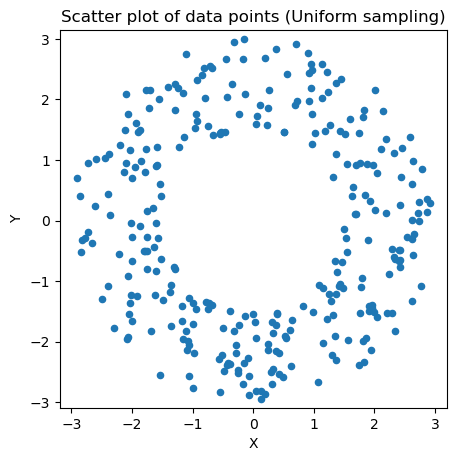

In [4]:
annulus = eg.annulus_example(R=1.5,d=1.5,n=300,Jacobian=False)
#annulus = np.loadtxt('Example1_d=0.5.txt')
#The examples.py generates data points in form of point clouds that can be analyzed using the imported dionysus module.
#plt.rcParams['lines.markersize'] = 150
#annulus=np.transpose(annulus)
plt.figure(figsize=(5,5), dpi=100)
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', 'datalim')

scatter(annulus.T[0,:],annulus.T[1,:],s=20)
plt.axis('equal')
plt.title('Scatter plot of data points (Uniform sampling)')
plt.show()

# np.savetxt('Example1_d=7.5.txt',annulusJ)

data = annulus

In [5]:
import scipy as spy
def boundary_cocycles(rout, epsilon):
    # Construct 𝛿⁰
    distances = rout["dperm2all"]
    edges = array((distances<=epsilon).nonzero()).T

    I = c_[arange(edges.shape[0]),arange(edges.shape[0])]
    I = I.flatten()
    J = edges.flatten()
    V = c_[-1 * ones(edges.shape[0]), ones(edges.shape[0])]
    V = V.flatten()

    Delta = spy.sparse.coo_matrix((V,(I,J)), shape=(edges.shape[0], distances.shape[0]))
    # Extract the cocycles
    cocycles = []
    cocycles_val = []
    for cocycle in rout["cocycles"][1]:
        val = cocycle[:,2]
        val[val > (prime-1)/2] -= prime
        Y = spy.sparse.coo_matrix((val,(cocycle[:,0],cocycle[:,1])), shape=(distances.shape[0],distances.shape[0]))
        Y = Y - Y.T
        Z = zeros((Delta.shape[0],))
        Z = Y[edges[:,0],edges[:,1]]
        cocycles.append(Z)
        cocycles_val.append(val)
    return Delta,cocycles,cocycles_val

# try

In [6]:
lp = 1
lq = 2
overall_coords = np.zeros(data.shape[0], dtype = float)
d = 1
lambda_parameter = 0
steps = 100

In [7]:
# run PH and get cocycle
diagrams = ripser(data, coeff=prime, do_cocycles=True)

# choose distance threshold epsilon
longest = np.diff(diagrams["dgms"][1]).argmax()
chosen_cocycle = diagrams['cocycles'][1][longest]
birth, death = diagrams["dgms"][1][longest]
gig_comp = np.max(diagrams["dgms"][0][np.isfinite(diagrams["dgms"][0])]) # 
if gig_comp < death:
    epsilon = max(birth, gig_comp)
else:
    epsilon = birth

# epsilon = min(birth+.1,birth+.5*(death-birth)) # if birth as epsilon gives problems try this
# if gig_comp < death:
#     epsilon = max(epsilon, gig_comp)
# else:
#     epsilon = epsilon

# smooth cocycle and get boundary
Delta, cocycles, cocycles_val = boundary_cocycles(diagrams, epsilon)
from scipy.sparse.linalg import lsqr
coord = lsqr(Delta, array(cocycles[longest]).squeeze() )
l2_cocycle = coord[0]
f = array(cocycles[longest]).squeeze()
B_mat = Delta.todense()
l2_cocycle = l2_cocycle.reshape(-1, 1)
z_init = l2_cocycle
##It does not seem to work to have double invokes here...      
import tensorflow as tf
z = tf.Variable(z_init, name='z', trainable=True, dtype=tf.float64)
trainable_variables = [z]

In [8]:
def loss_function():
    cost_z = (1-lambda_parameter)*tf.math.pow( tf.math.reduce_sum( tf.math.pow( tf.abs(f - tf.linalg.matmul(B_mat,z) ),lp ) ), 1/lp) + lambda_parameter*tf.math.pow( tf.math.reduce_sum( tf.math.pow( tf.math.abs(f - tf.linalg.matmul(B_mat,z) ),lq ) ), 1/lq)
    return cost_z
tf.random.set_seed(1)
optimizer = tf.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4) #Not recommended if you are not using tensorflow-gpu, may result a different result sometimes.
B_mat = tf.Variable(B_mat, name="B_mat", trainable=False, dtype=tf.float64)
f = tf.Variable(f, name="f", trainable=False, dtype=tf.float64)

if int(10)>0:
    print('Before optim cost:',loss_function().numpy())
    for i in range(int(10)):
        train = optimizer.minimize(loss_function, var_list=trainable_variables)
        #err = np.sum(np.abs(z.numpy() - z_init))
        #print('>>> step',train.numpy(),' err=',err)
    print('After  optim cost:',loss_function().numpy(),' in ',train.numpy(),' steps')
    res_tf=z.numpy()
else:
    print('Non-optimized cost:',loss_function().numpy())
    res_tf=z_init

color = np.mod(res_tf.T[0,:]/res_tf.max(),1).T

Before optim cost: 143209.3588525538
After  optim cost: 139878.27557694959  in  10  steps


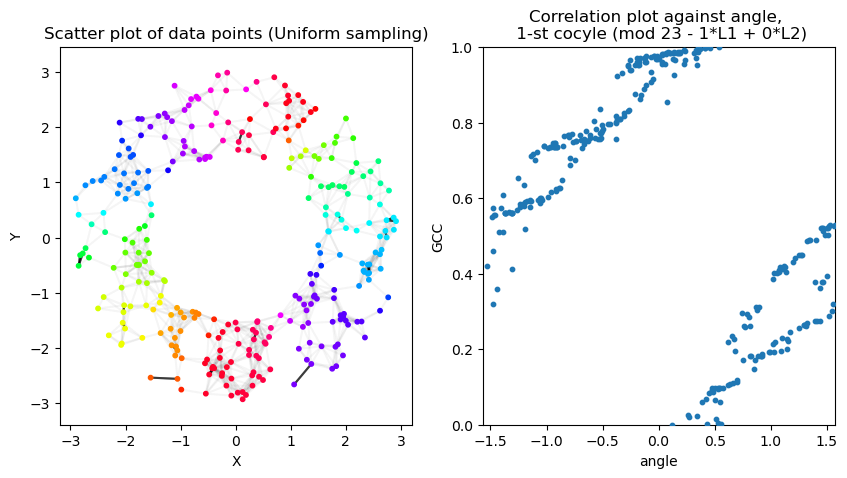

In [9]:
# plot function
plt.figure(figsize=(10,5), dpi=100)
plt.subplot(1,2,1)
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', 'datalim')
scatter(data.T[0,:],data.T[1,:],
        c=color,cmap=cm.hsv,s=10,vmin=0,vmax=1)
plt.title('Scatter plot of data points (Uniform sampling)')


S,T = np.nonzero(diagrams['dperm2all']<epsilon)
val = mod(array(coord[0]), 1.0)
for e in c_[data[S],data[T]][abs(val[S]-val[T])<toll]:
    plot(e[[0,2]],e[[1,3]],c='k',alpha=.5,zorder=0)
for e in c_[data[S],data[T]]:
    plot(e[[0,2]],e[[1,3]],c='k',alpha=.02,zorder=0)
# plt.show()

# fig = plt.figure(figsize=(5,5), dpi=100)

plt.subplot(1,2,2)
angle = np.arctan(data.T[0,:]/data.T[1,:])
plt.scatter(angle,color,s=10, c='C0',zorder=10)
plt.ylim([0,1])
plt.xlim([-np.pi/2,np.pi/2])
plt.xlabel('angle')
plt.ylabel('GCC')
plt.title('Correlation plot against angle, \n {}-st cocyle (mod {} - {}*L{} + {}*L{})'.format(1,prime,1-lambda_parameter,lp,lambda_parameter,lq))
plt.show()

# the real figure

Before optim cost: 39255.78714744096
After  optim cost: 29768.501487287052  in  100  steps


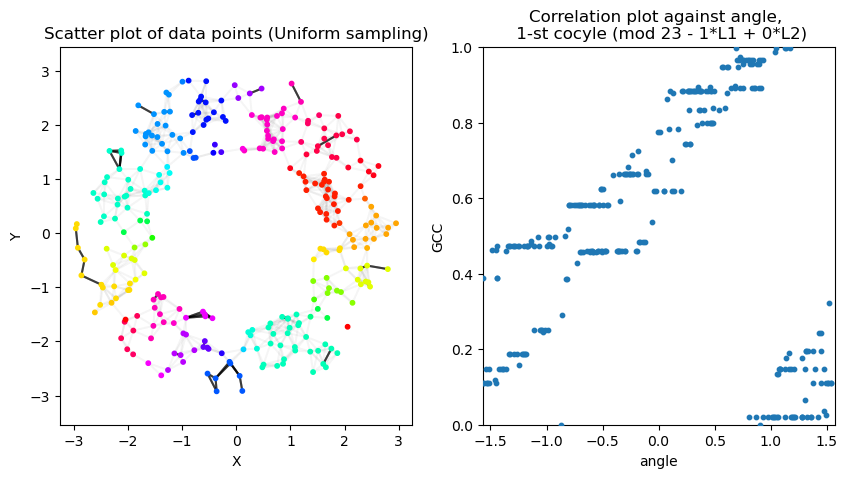

Before optim cost: 14931.597896837604
After  optim cost: 13721.758813822868  in  100  steps


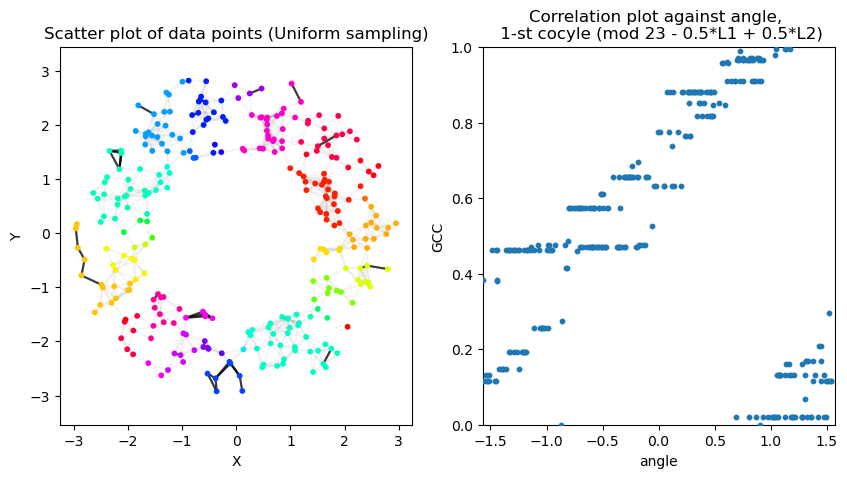

Before optim cost: 94.40891454530545
After  optim cost: 92.43879699088615  in  100  steps


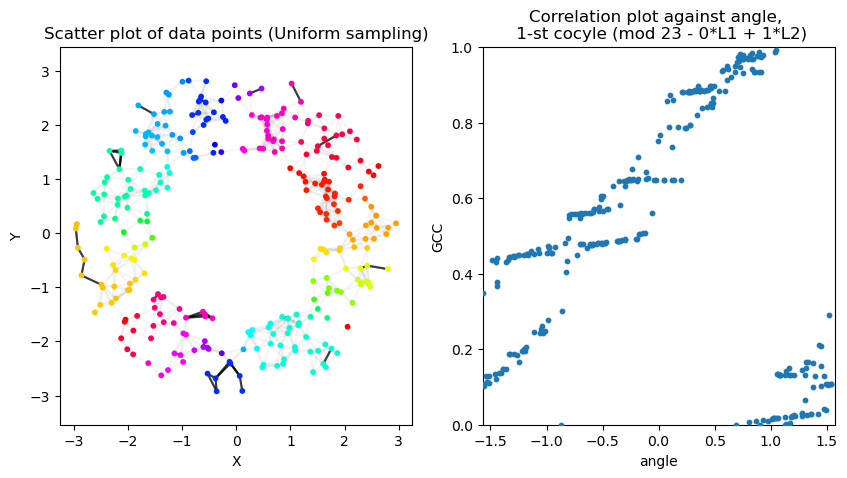

In [10]:

# create the data set
data = eg.annulus_example(R=1.5,d=1.5,n=300,Jacobian=False)

# run PH and get cocycle
diagrams = ripser(data, coeff=prime, do_cocycles=True)

# choose distance threshold epsilon
longest = np.diff(diagrams["dgms"][1]).argmax()
chosen_cocycle = diagrams['cocycles'][1][longest]
birth, death = diagrams["dgms"][1][longest]
gig_comp = np.max(diagrams["dgms"][0][np.isfinite(diagrams["dgms"][0])]) # 
if gig_comp < death:
    epsilon = max(birth, gig_comp)
else:
    epsilon = birth

# epsilon = min(birth+.1,birth+.5*(death-birth)) # if birth as epsilon gives problems try this
# if gig_comp < death:
#     epsilon = max(epsilon, gig_comp)
# else:
#     epsilon = epsilon

# smooth cocycle and get boundary
Delta, cocycles, cocycles_val = boundary_cocycles(diagrams, epsilon)
from scipy.sparse.linalg import lsqr
coord = lsqr(Delta, array(cocycles[longest]).squeeze() )
l2_cocycle = coord[0]
f = array(cocycles[longest]).squeeze()
B_mat = Delta.todense()
l2_cocycle = l2_cocycle.reshape(-1, 1)
z_init = l2_cocycle
##It does not seem to work to have double invokes here...      
import tensorflow as tf
z = tf.Variable(z_init, name='z', trainable=True, dtype=tf.float64)
trainable_variables = [z]

# ---- run TF
for lambda_parameter in [0,.5,1]:
    def loss_function():
        cost_z = (1-lambda_parameter)*tf.math.pow( tf.math.reduce_sum( tf.math.pow( tf.abs(f - tf.linalg.matmul(B_mat,z) ),lp ) ), 1/lp) + lambda_parameter*tf.math.pow( tf.math.reduce_sum( tf.math.pow( tf.math.abs(f - tf.linalg.matmul(B_mat,z) ),lq ) ), 1/lq)
        return cost_z
    tf.random.set_seed(1)
    optimizer = tf.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4) #Not recommended if you are not using tensorflow-gpu, may result a different result sometimes.
    B_mat = tf.Variable(B_mat, name="B_mat", trainable=False, dtype=tf.float64)
    f = tf.Variable(f, name="f", trainable=False, dtype=tf.float64)

    if int(steps)>0:
        print('Before optim cost:',loss_function().numpy())
        for i in range(int(steps)):
            train = optimizer.minimize(loss_function, var_list=trainable_variables)
            #err = np.sum(np.abs(z.numpy() - z_init))
            #print('>>> step',train.numpy(),' err=',err)
        print('After  optim cost:',loss_function().numpy(),' in ',train.numpy(),' steps')
        res_tf=z.numpy()
    else:
        print('Non-optimized cost:',loss_function().numpy())
        res_tf=z_init

    color = np.mod(res_tf.T[0,:]/res_tf.max(),1).T

    # plot function
    plt.figure(figsize=(10,5), dpi=100)
    plt.subplot(1,2,1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().set_aspect('equal', 'datalim')
    scatter(data.T[0,:],data.T[1,:],
            c=color,cmap=cm.hsv,s=10,vmin=0,vmax=1)
    plt.title('Scatter plot of data points (Uniform sampling)')


    S,T = np.nonzero(diagrams['dperm2all']<epsilon)
    val = mod(array(coord[0]), 1.0)
    for e in c_[data[S],data[T]][abs(val[S]-val[T])<toll]:
        plot(e[[0,2]],e[[1,3]],c='k',alpha=.5,zorder=0)
    for e in c_[data[S],data[T]]:
        plot(e[[0,2]],e[[1,3]],c='k',alpha=.02,zorder=0)
    # plt.show()

    # fig = plt.figure(figsize=(5,5), dpi=100)

    plt.subplot(1,2,2)
    angle = np.arctan(data.T[0,:]/data.T[1,:])
    plt.scatter(angle,color,s=10, c='C0',zorder=10)
    plt.ylim([0,1])
    plt.xlim([-np.pi/2,np.pi/2])
    plt.xlabel('angle')
    plt.ylabel('GCC')
    plt.title('Correlation plot against angle, \n {}-st cocyle (mod {} - {}*L{} + {}*L{})'.format(1,prime,1-lambda_parameter,lp,lambda_parameter,lq))
    plt.show()

Before optim cost: 75796.07237951126
After  optim cost: 59420.421838169445  in  100  steps


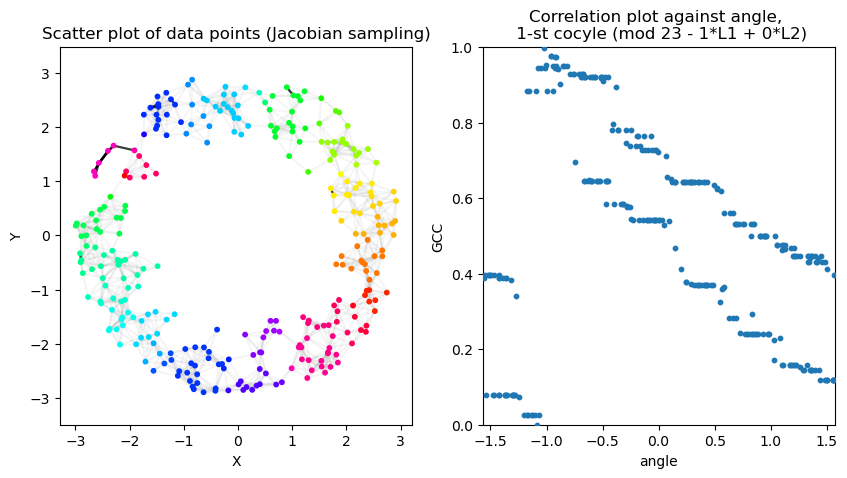

Before optim cost: 29764.015160957355
After  optim cost: 27355.390479421636  in  100  steps


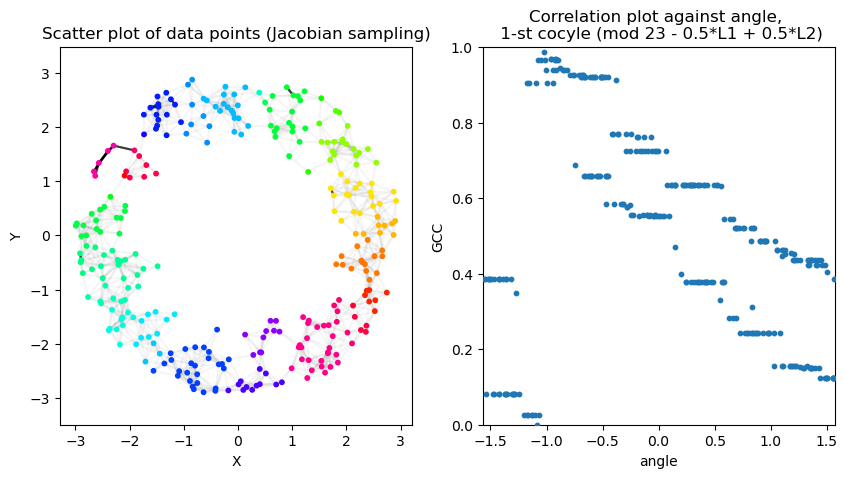

Before optim cost: 107.71025141005848
After  optim cost: 104.45927580742475  in  100  steps


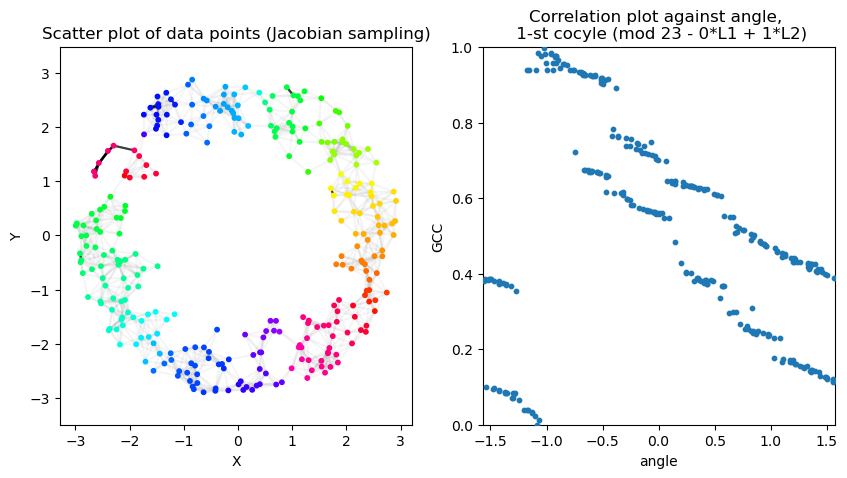

In [12]:

# create the data set
data = eg.annulus_example(R=1.5,d=1.5,n=300,Jacobian=True)

# run PH and get cocycle
diagrams = ripser(data, coeff=prime, do_cocycles=True)

# choose distance threshold epsilon
longest = np.diff(diagrams["dgms"][1]).argmax()
chosen_cocycle = diagrams['cocycles'][1][longest]
birth, death = diagrams["dgms"][1][longest]
gig_comp = np.max(diagrams["dgms"][0][np.isfinite(diagrams["dgms"][0])]) # 
if gig_comp < death:
    epsilon = max(birth, gig_comp)
else:
    epsilon = birth

# epsilon = min(birth+.1,birth+.5*(death-birth)) # if birth as epsilon gives problems try this
# if gig_comp < death:
#     epsilon = max(epsilon, gig_comp)
# else:
#     epsilon = epsilon

# smooth cocycle and get boundary
Delta, cocycles, cocycles_val = boundary_cocycles(diagrams, epsilon)
from scipy.sparse.linalg import lsqr
coord = lsqr(Delta, array(cocycles[longest]).squeeze() )
l2_cocycle = coord[0]
f = array(cocycles[longest]).squeeze()
B_mat = Delta.todense()
l2_cocycle = l2_cocycle.reshape(-1, 1)
z_init = l2_cocycle
##It does not seem to work to have double invokes here...      
import tensorflow as tf
z = tf.Variable(z_init, name='z', trainable=True, dtype=tf.float64)
trainable_variables = [z]

# ---- run TF
for lambda_parameter in [0,.5,1]:
    def loss_function():
        cost_z = (1-lambda_parameter)*tf.math.pow( tf.math.reduce_sum( tf.math.pow( tf.abs(f - tf.linalg.matmul(B_mat,z) ),lp ) ), 1/lp) + lambda_parameter*tf.math.pow( tf.math.reduce_sum( tf.math.pow( tf.math.abs(f - tf.linalg.matmul(B_mat,z) ),lq ) ), 1/lq)
        return cost_z
    tf.random.set_seed(1)
    optimizer = tf.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4) #Not recommended if you are not using tensorflow-gpu, may result a different result sometimes.
    B_mat = tf.Variable(B_mat, name="B_mat", trainable=False, dtype=tf.float64)
    f = tf.Variable(f, name="f", trainable=False, dtype=tf.float64)

    if int(steps)>0:
        print('Before optim cost:',loss_function().numpy())
        for i in range(int(steps)):
            train = optimizer.minimize(loss_function, var_list=trainable_variables)
            #err = np.sum(np.abs(z.numpy() - z_init))
            #print('>>> step',train.numpy(),' err=',err)
        print('After  optim cost:',loss_function().numpy(),' in ',train.numpy(),' steps')
        res_tf=z.numpy()
    else:
        print('Non-optimized cost:',loss_function().numpy())
        res_tf=z_init

    color = np.mod(res_tf.T[0,:]/res_tf.max(),1).T

    # plot function
    plt.figure(figsize=(10,5), dpi=100)
    plt.subplot(1,2,1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().set_aspect('equal', 'datalim')
    scatter(data.T[0,:],data.T[1,:],
            c=color,cmap=cm.hsv,s=10,vmin=0,vmax=1)
    plt.title('Scatter plot of data points (Jacobian sampling)')


    S,T = np.nonzero(diagrams['dperm2all']<epsilon)
    val = mod(array(coord[0]), 1.0)
    for e in c_[data[S],data[T]][abs(val[S]-val[T])<toll]:
        plot(e[[0,2]],e[[1,3]],c='k',alpha=.5,zorder=0)
    for e in c_[data[S],data[T]]:
        plot(e[[0,2]],e[[1,3]],c='k',alpha=.02,zorder=0)
    # plt.show()

    # fig = plt.figure(figsize=(5,5), dpi=100)

    plt.subplot(1,2,2)
    angle = np.arctan(data.T[0,:]/data.T[1,:])
    plt.scatter(angle,color,s=10, c='C0',zorder=10)
    plt.ylim([0,1])
    plt.xlim([-np.pi/2,np.pi/2])
    plt.xlabel('angle')
    plt.ylabel('GCC')
    plt.title('Correlation plot against angle, \n {}-st cocyle (mod {} - {}*L{} + {}*L{})'.format(1,prime,1-lambda_parameter,lp,lambda_parameter,lq))
    plt.show()